# Astrometry Response functions (Maps)

In [1]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
import os

#import inspect

We use Mollview from healpy to plot a Map in Mollweide projection with an array given. With Mollview, the standard coordinates are **spherical** with the co-latitude $\theta \in [0,\pi]$ (North pole to South pole),  and the longitude $\phi \in [0, 2\pi]$ eastward. For the projection, $\phi = 0$ is at the center and increases eastward towards the left of the map.

## Some important asumptions
$\bf v$, our velocity with respect to the cosmic frame. In galactic coordinates its direction is along $(l,b)=(264^{\circ},48^{\circ})$, or $(RA,Dec)=(167.78^{\circ}, -7.145^{\circ})$ in equatorial coordinates.
According to CMB observations $\beta = v/c\,=\,1.23\times 10^{-3}$.

We will work in the Galactic coordinates, which means to consider the Sun as the origin of spherical coordinates. This means the angle $b$ is related to the co-latitude $\theta$ (for the representation with Mollview) as $\theta = \pi/2 -b$, whereas the latitute remains the same.

In [2]:
# Conversion between b and \theta
v_theta = (np.pi/2)-np.radians(48) # (pi/2 - b) E[0,pi]
v_phi = np.radians(264) # l E[0,2pi]

In [3]:
# The next function returns a unit vector in R3. 
# Given two angles, \theta E[0,pi] and \phi E[0,2pi], skyvec give us its cartesian coordinates:
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

print(skyvec(2,3))
print(np.dot(skyvec(2,3),skyvec(2,3)))

[-0.90019763  0.12832006 -0.41614684]
1.0


# Response functions

In the next cells we define the response functions $C_1, C_2, C_3, C_{null}, C_{dip}, C_{mon}$ as in the overleaf. 

At the begining we define the function **vecdot** to be able to calculate the product vector of an array of vectors $\bf n$, and a vector given $\bf n'$. An example of this fuction is provided below the definition.

In [4]:
def vecdot(a,b): # (N,3) vectors
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)
    dot = np.sum(a*b,axis=0)
    return dot
    
a=np.array([[0,1,2],[3,4,5],[6,7,8],[9,10,11]]).T#.reshape(3,4)
b=np.array([[0, 1, 1]]).reshape(3,1)
print(b)
print(np.shape(a))
print(np.shape(b))
adotb=vecdot(a,b)
print(adotb)

[[0]
 [1]
 [1]]
(3, 4)
(3, 1)
[ 3  9 15 21]


In [5]:
beta = 1.23e-3
n_Om = 0

# Hola looks for zeros in an array of numbers.
def hola(y):
    return np.where(y == 0, 0, np.log(y))

print(hola(np.array([2,3,1,4,5])))

def F0(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = np.pi*(1- 8*y +7*(y**2) - 6*(y**2)*hola(y))
    den = 3* ((1-y)**2)
    return num/den

def F1(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = -np.pi*(2*y -1) *((y-1)*(2*y +1) - 3*y*hola(y))
    den = 6*((y-1)**3)
    return num/den

def F2(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    num = np.pi*y*((y-1)*(2*y +1) - 3*y*hola(y))
    den = 3*((y-1)**2)
    return num/den

def C1(v,n1,n2):
    y = (1-vecdot(n1,n2))/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    f0 = F0(v,n1,n2)
    f2 = F2(v,n1,n2)
    C1 = -8*y*((y-1)**2)*f0 - 8*beta*(4-n_Om)*y*(y-1)*f2*(n1v+n2v)
    return C1

def C2(v,n1,n2):
    y = (1-vecdot(n1,n2))/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    f0 = F0(v,n1,n2)
    f2 = F2(v,n1,n2)
    C2 = 2*(y-1)*f0*(n1v*(2*y -1) + n2v) + 2*beta*(4-n_Om)*f2*(n1v+n2v)*(n1v*(2*y -1) + n2v)
    return C2

def C3(v,n1,n2):
    y = (1-vecdot(n1,n2))/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    f0 = F0(v,n1,n2)
    f2 = F2(v,n1,n2)
    C3 = 2*n1v*(y-1)*f0*(n1v + (2*y -1)*n2v) + 2*beta*(n_Om-4)*f2*(n1v+n2v)*(n1v*n2v*(2*y -1)+(n2v)**2 +4*(y-1)*y)
    return C3


[0.69314718 1.09861229 0.         1.38629436 1.60943791]


In [6]:
def Cnull(v,p,q):
    y = (1-vecdot(p,q))/2
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    f0 = F0(v,p,q)
    f2 = F2(v,p,q)
    Cnull = C1(v,p,q) + ((4*(y-1)*y)/(n1v*(2*y-1) +n2v))*C2(v,p,q)
    return Cnull

def Cdip(v,p,q):
    y = (1-vecdot(p,q))/2
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    Cdip = ((n1v*(n1v + n2v*(2*y -1))*C1(v,p,q))/(4*(y-1)*y) + C3(v,p,q))/beta
    return Cdip

def Cmon(v,p,q):
    y = (1-vecdot(p,q))/2
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    Cmon =  ( (n1v*n2v*(2*y-1) + n2v**2 + 4*(y-1)*y)*C1(v,p,q) )/(4*(1-y)*y) + C3(v,p,q)
    return Cmon

#print(inspect.getsource(F0))

## Test with the functions defined above
For two random unit vectors $\bf n$, and $\bf v$, $\bf n'$ fixed. 

In [7]:
np.random.seed(4)
random_vector = np.random.randn(3)
random_vector2 = np.random.randn(3)
random_vector3 = np.random.randn(3)

n11 = random_vector / np.linalg.norm(random_vector)
n12 = random_vector2 / np.linalg.norm(random_vector2)

print('n11:', n11)
print('n12:', n12)
# To make sure they are unit vectors
print(np.dot(n11,n11))

# Array of two vectors, similar to the array that we will have afterwards with the hp.pix2ang
ndir = np.array([n11,n12]).T

v = skyvec(v_theta, v_phi).reshape(3,1)
n2 = np.array([0,1,0]).reshape(3,1)

print('ndir:', ndir)
print('n2:', n2)
print('v:', v)

y11 = (1-vecdot(np.array([n11]).T,n2))/2
pv11 = vecdot(np.array([n11]).T,v)
qv11 = vecdot(n2,v)
C1s11 = C1(v,np.array([n11]).T,n2)
C2s11 = C2(v,np.array([n11]).T,n2)
Cnull_11 = C1s11 + ((4*(y11-1)*y11)/(pv11*(2*y11 -1) +qv11))*C2s11

print('n11dotn2',vecdot(np.array([n11]).T,n2))
print('n11dotV:',pv11)
print('n2dotV:',qv11)
print('Cnull_11 (different way of calculation):',Cnull_11)

print('C1_11:', C1(v,np.array([n11]).T,n2))
print('C2_11:', C2(v,np.array([n11]).T,n2))
print('Cnull_11:',Cnull(v,np.array([n11]).T,n2))

print('C1_ndir:',C1(v,ndir,n2))
print('C2_ndir:',C2(v,ndir,n2))
print('Cnull_ndir:',Cnull(v,ndir,n2))

n11: [ 0.04532646  0.44818547 -0.89279073]
n12: [ 0.38975189 -0.23505501 -0.8904171 ]
1.0000000000000002
ndir: [[ 0.04532646  0.38975189]
 [ 0.44818547 -0.23505501]
 [-0.89279073 -0.8904171 ]]
n2: [[0]
 [1]
 [0]]
v: [[-0.06994319]
 [-0.66546504]
 [ 0.74314483]]
n11dotn2 [0.44818547]
n11dotV: [-0.96489485]
n2dotV: [-0.66546504]
Cnull_11 (different way of calculation): [-2.77555756e-17]
C1_11: [0.19973078]
C2_11: [-0.05823823]
Cnull_11: [-2.77555756e-17]
C1_ndir: [0.19973078 0.86688887]
C2_ndir: [-0.05823823 -0.7254834 ]
Cnull_ndir: [-2.77555756e-17  0.00000000e+00]


In [8]:
# Random unit vector n'
np.random.seed(5)
random_vector = np.random.randn(3)
unit_vector = random_vector / np.linalg.norm(random_vector)
print(unit_vector)
print(np.dot(unit_vector,unit_vector))

# Remember .T is not the same as .reshape()
print('Random Vector:',random_vector)
print(unit_vector.T) 
print(unit_vector.reshape(3,1))

[ 0.17701851 -0.13274364  0.97521463]
1.0
Random Vector: [ 0.44122749 -0.33087015  2.43077119]
[ 0.17701851 -0.13274364  0.97521463]
[[ 0.17701851]
 [-0.13274364]
 [ 0.97521463]]


# Changing the color of the map according to a function

We want to evaluate our scalar functions defined above with respect to the coordinates of $\bf n$ when we set $\bf v$ and $\bf n'$, in that sense, the coordinates of the pixels in the Map will be the direction of $\bf n$. We obtain the directions of each pixel with hp.pix2ang. 

The number of pixels are given by $N_{pix}= 12\times Nside^2$ (the higher the number of pixels are, the better the resolution is). $N_{side}$ parameter is generally a power of 2.

dir type: <class 'numpy.ndarray'>
dir shape: (3, 12288)
v shape: (3, 1)
vn shape: (3, 1)
vn angles: (array([2.40855437]), array([1.46607657]))


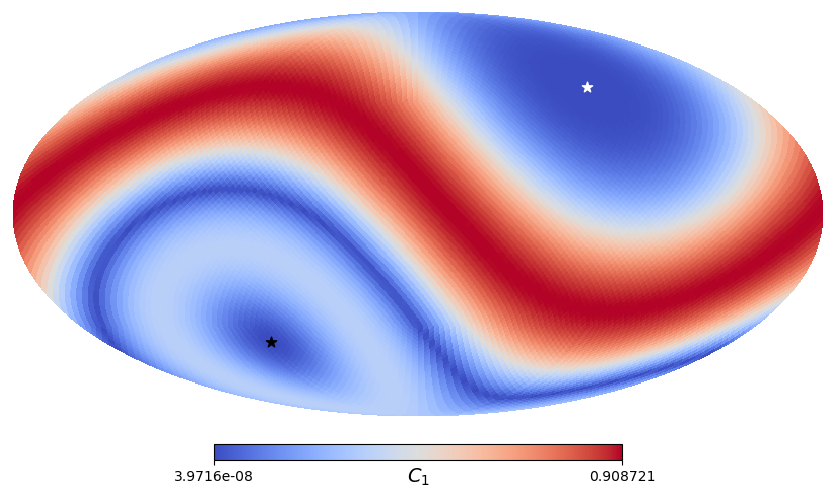

In [31]:
Nside = 32 
Npix = hp.nside2npix(Nside)
theta, phi = hp.pix2ang(Nside, np.arange(Npix))
dir = skyvec(theta,phi) #.T#.reshape(npix,3)


######### Ameek's values #########
theta1, phi1 = (np.pi/2,0)
n1 = skyvec(theta1,phi1).reshape(3,1)

theta0 = np.deg2rad(48) 
phi0 = np.deg2rad(264)
# vvec = np.array([0,0,1])
vvec = skyvec(theta0,phi0).reshape(3,1)
##################################


v = skyvec(v_theta, v_phi).reshape(3,1)
#vn = skyvec(v_theta, v_phi).reshape(3,1) # Same direction as velocity 
#vn = skyvec(v_theta, v_phi+0.2).reshape(3,1) # Close to the velocity
vn = -1.*np.array(v) # Opposite to the velocity
#vn = skyvec(0, 0).reshape(3,1)
#vn = unit_vector.reshape(3,1) # Random position for n'
vs = -1.*np.array(v)  # Vector in opposite direction to V.
thetaVn, phiVn = hp.vec2ang(vn)
thetaVs, phiVs = hp.vec2ang(vs)

print('dir type:',type(vn))
print('dir shape:',np.shape(dir))
print('v shape:',np.shape(v))
print('vn shape:',np.shape(vn))
print('vn angles:', (thetaVn, phiVn))

Map_C1 = C1(v,dir,vn)
col_Map = 'coolwarm' #'Blues'

hp.mollview(abs(Map_C1),cmap= col_Map,cbar=True, unit=r'$C_{1}$',title=r'')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='w')
#hp.projscatter(theta0,phi0,marker='*',s=60,color='y')
#hp.projscatter(theta1,phi1,marker='*',s=60,color='k')
#hp.projscatter(theta1,phi1,marker='*',s=60,color='g')
#hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=60,color='k') 
#hp.graticule()

plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/C1.pdf')#,bbox_inches='tight')


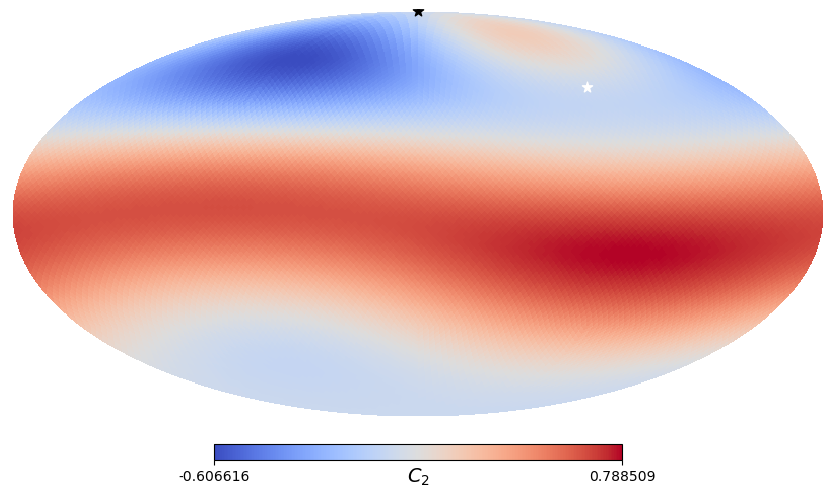

In [10]:
Map_C2 = C2(v,dir,vn)
hp.mollview(Map_C2,title=r'',cmap= col_Map,cbar=True, unit=r'$C_{2}$' )
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='w')
#hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='gold',coord=['E','G'])
hp.projscatter(thetaVn,phiVn,marker='*',s=60,color='k')  


plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/C2.pdf')#,bbox_inches='tight')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_11_StarCloseToV.pdf')


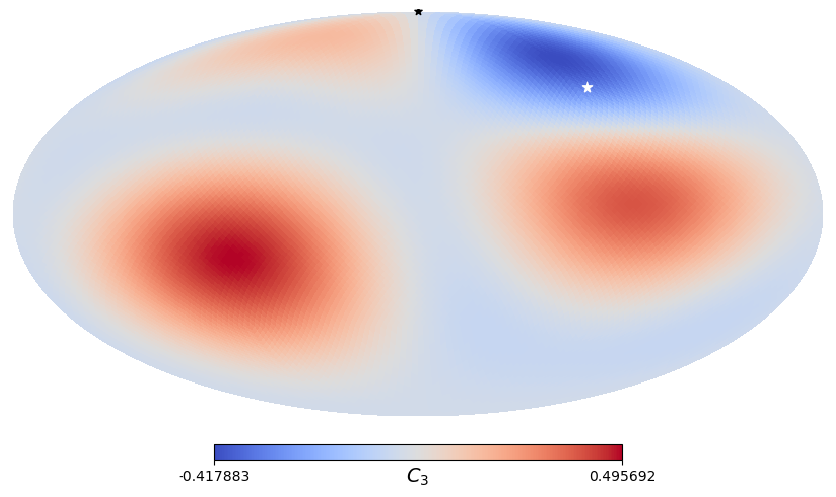

In [11]:
Map_C3 = C3(v,dir,vn)
hp.mollview(Map_C3,title=r'',cmap= col_Map,cbar=True, unit=r'$C_{3}$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='w')
#hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='gold',coord=['E','G'])
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k')  

plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/C3.pdf')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_22_StarCloseToV.pdf')


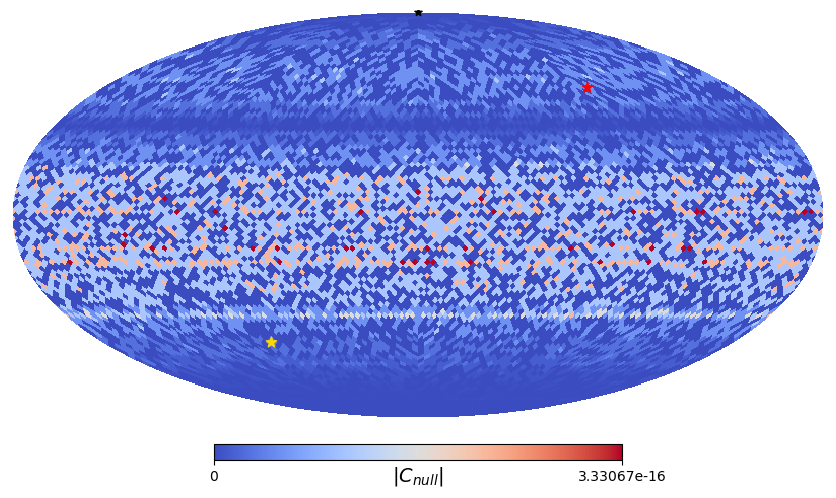

In [12]:
Map_Cnull = Cnull(v,dir,vn)

hp.mollview(abs(Map_Cnull),title=r'',cmap= col_Map,cbar=True, unit=r'$|C_{null}|$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r')
hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k')  

plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/Cnull.pdf')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_ii_StarCloseToV.pdf')

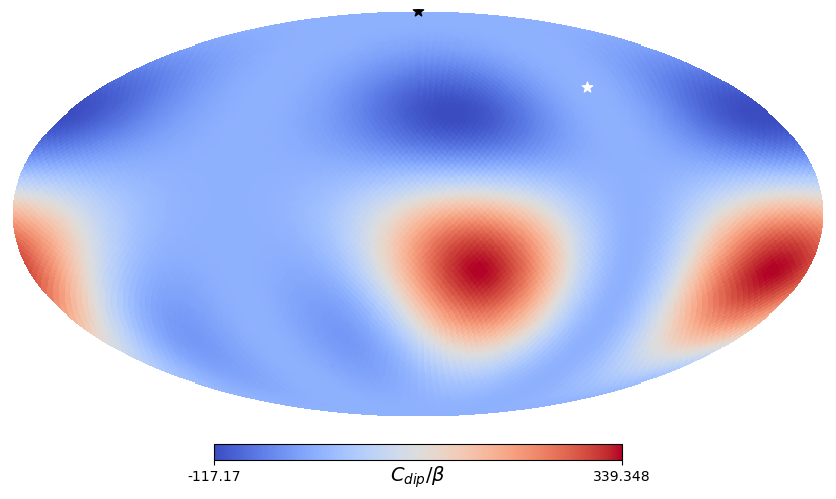

In [13]:
Map_Cdip = Cdip(v,dir,vn)/beta

hp.mollview(Map_Cdip,title=r'',cmap= col_Map,cbar=True, unit=r'$C_{dip}/\beta$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='w')
#hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=60,color='k')  

plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/Cdip.pdf')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_ii_StarCloseToV.pdf')


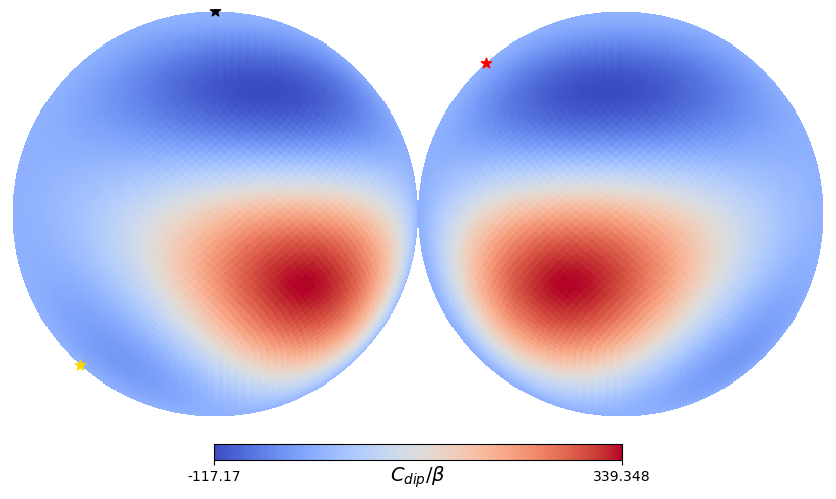

In [14]:
Map_Cdip = Cdip(v,dir,vn)/beta

hp.orthview(Map_Cdip,title=r'',cmap= col_Map,cbar=True, unit=r'$C_{dip}/\beta$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r')
hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=60,color='k')

plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/Cdip_Orthographic.pdf')

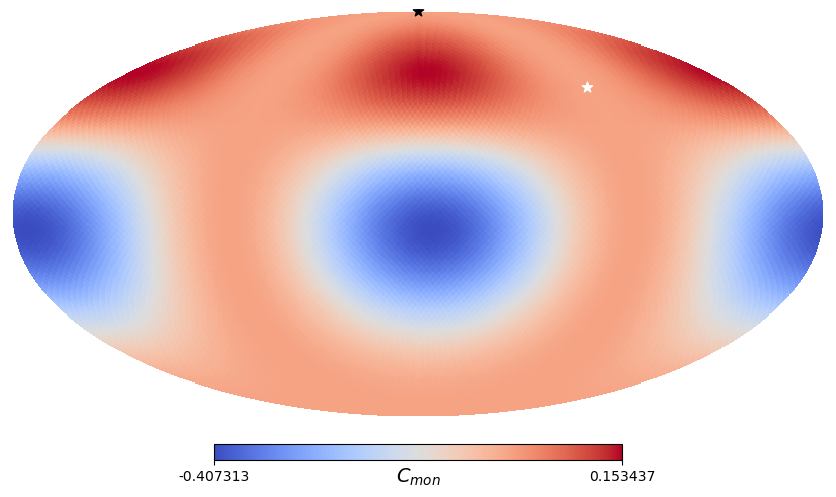

In [15]:
Map_Cmon = Cmon(v,dir,vn)

hp.mollview(Map_Cmon,title=r'',cmap= col_Map,cbar=True, unit=r'$C_{mon}$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='w')
#hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='gold',coord=['E','G'])
hp.projscatter(thetaVn,phiVn,marker='*',s=60,color='k')  

plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/Cmon.pdf')
#plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/StarCloseToV/H_ii_StarCloseToV.pdf')


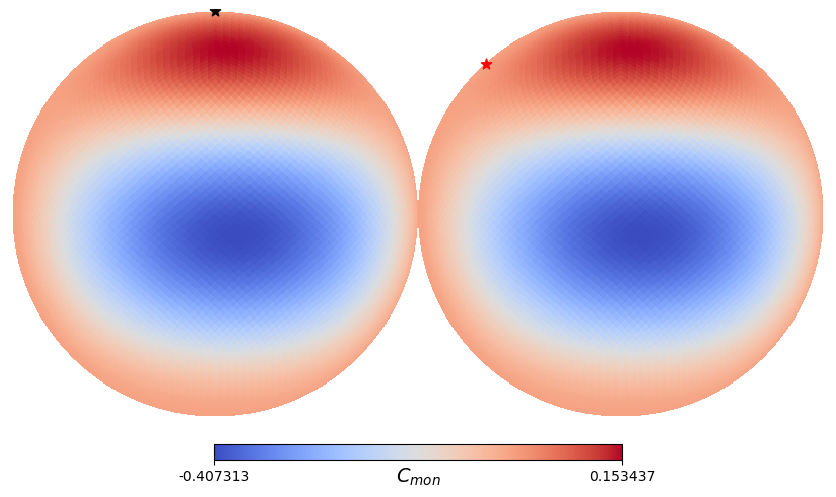

In [16]:
Map_Cmon = Cmon(v,dir,vn)

hp.orthview(Map_Cmon,title=r'',cmap= col_Map,cbar=True, unit=r'$C_{mon}$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r')
#hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='gold')
hp.projscatter(thetaVn,phiVn,marker='*',s=60,color='k')  

plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/Cmon_Orthographic.pdf')

## Getting the Galactic coordinates of $n'$ (Black Star)

Astropy help us to do that, but it needs the longitude (Right Ascension) and latitude (Declination) of the point. Fortunately, healpy give us this angles in degrees with **hp.vec2ang(vectorInR3, lonlat=True)**, if lonlat=False, the function returns a tuple of two arrays with co-latitude and longitude in radians.

In [17]:
l, b = hp.vec2ang(vn, lonlat=True)
print(l, b)

# To make sure the code is working we calculate the RA and Dec of v, wh
l_CMB, b_CMB = hp.vec2ang(v, lonlat=True)
print(l_CMB, b_CMB)

[0.] [90.]
[264.] [48.]


In [18]:
from astropy.coordinates import SkyCoord
import astropy.units as u

RA = 167.78
Dec = -7.145

# Create a SkyCoord object using degrees
coord = SkyCoord(ra=RA * u.degree, dec=Dec * u.degree, frame='icrs')

# Convert to Galactic coordinates
galactic_coord = coord.galactic

# Output Galactic coordinates
print(f"Galactic Longitude (l): {galactic_coord.l.deg} degrees")
print(f"Galactic Latitude (b): {galactic_coord.b.deg} degrees")


Galactic Longitude (l): 263.99157457742655 degrees
Galactic Latitude (b): 47.99662303054817 degrees
